Dans ce notebook, nous avons créé un moteur de recherche qui parcourt la collection de questions StackOverFlow Python et récupère les questions et les tags les plus similaires à la question d'entrée

In [38]:
from IPython.core.display import display
!pip install transformers

In [2]:
!pip install simpletransformers==0.32.3

In [3]:
!pip install wordcloud

In [4]:
!pip install torch

In [5]:
import pandas as pd
from nltk.corpus import stopwords
import re
from wordcloud import WordCloud , STOPWORDS
import matplotlib.pyplot as plt
from transformers import (GPT2Config,GPT2LMHeadModel,GPT2Tokenizer)
from tqdm.notebook import tqdm
import torch

pd.set_option('display.max_colwidth', None)

In [6]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/fedecabre/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [7]:
#questions = pd.read_csv("input/Questions.csv", encoding = "ISO-8859-1")
#print(len(questions))
#display(questions.head(5))

dtypes_questions = {'Id':'int32', 'Score': 'int16', 'Title': 'str',
                    'Body': 'str', 'Title_raw': 'str', 'Text': 'str'}

nrows = 1000

df_questions = pd.read_csv('df_questions_fullclean.csv',
                           usecols=dtypes_questions.keys(),
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           nrows=nrows
                          )

df_tags_list = pd.read_csv('tags_list.csv',
                           usecols=['Id', 'Tags'],
                           encoding = "utf-8",
                           dtype=dtypes_questions,
                           #nrows=nrows # un post peut avoir plusieurs tags
                          )
print(len(df_questions))
display(df_questions.head(5))
display(df_tags_list.head(5))

1000


,Id,Title,Body,Score,Title_raw,Text
0,3624753,provide initialization subclass namedtuple,namedtuple like edgebase namedtupleedgebase leave want custom hashfunction create follow class edgeedgebase def hashself return hashselfright since object want hashvalue calculate class edgeedgebase def initself leave selfhash hashselfleft def hashself return appear work really subclassing initialization python especially tuples pitfall solution recommend way thanks advance,52,How to provide additional initialization for a subclass of namedtuple?,provide initialization subclass namedtuple namedtuple like edgebase namedtupleedgebase leave want custom hashfunction create follow class edgeedgebase def hashself return hashselfright since object want hashvalue calculate class edgeedgebase def initself leave selfhash hashselfleft def hashself return appear work really subclassing initialization python especially tuples pitfall solution recommend way thanks advance
1,14670299,use stargazer rstudio knitr,struggle use stargazer output knitr use example paste code rmd file click knit html block render equation block stargazer remain paste block sweave file click compile pdf code render miktex instal version stargazer answer insert stargazer knitr document work sweave file rnw click pdf rmd file tex render click knit html put output rmd file knit convert latex code latex code apologise long segment beginaligned amp sigmayx doty amp rho x xz dotz amp beta z xy endaligned documentclassarticle begindocument table create stargazer v marek hlavac harvard university email hlavac fasharvardedu date time feb begintablehtb center caption label footnotesize hline ex multicolumnctextitdependent ex rate hline ex post hline ex observation std error df hline ex textitnote multicolumnrp p p normalsize enddocument,21,Using stargazer with Rstudio and Knitr,use stargazer rstudio knitr struggle use stargazer output knitr use example paste code rmd file click knit html block render equation block stargazer remain paste block sweave file click compile pdf code render miktex instal version stargazer answer insert stargazer knitr document work sweave file rnw click pdf rmd file tex render click knit html put output rmd file knit convert latex code latex code apologise long segment beginaligned amp sigmayx doty amp rho x xz dotz amp beta z xy endaligned documentclassarticle begindocument table create stargazer v marek hlavac harvard university email hlavac fasharvardedu date time feb begintablehtb center caption label footnotesize hline ex multicolumnctextitdependent ex rate hline ex post hline ex observation std error df hline ex textitnote multicolumnrp p p normalsize enddocument
2,16476413,panda dataframe via mysqldb database,mysql database python create select row question directly instruct mysqldb take dataframe insert exist need iterate row either case would python look like id two data column match dataframe,56,How to insert pandas dataframe via mysqldb into database?,panda dataframe via mysqldb database mysql database python create select row question directly instruct mysqldb take dataframe insert exist need iterate row either case would python look like id two data column match dataframe
3,1173463,recommendation window text editor r,recommendation window text editor r use work reasonably well know else people use,38,Recommendations for Windows text editor for R,recommendation window text editor r recommendation window text editor r use work reasonably well know else people use
4,10933945,norm vector r,norm think give result c sqrt return x error normx must numeric matrix asmatrixx normasmatrixx anyone know function calculate norm vector r,45,how to calculate the Euclidean norm of a vector in R?,norm vector r norm think give result c sqrt return x error normx must numeric matrix asmatrixx normasmatrixx anyone know function calculate norm vector r


,Id,Tags
0,3624753,python
1,3624753,inheritance
2,3624753,tuples
3,14670299,r
4,14670299,knitr


In [8]:
print(df_questions[['Title','Body']].head(10))


                                             Title  \
0       provide initialization subclass namedtuple   
1                      use stargazer rstudio knitr   
2             panda dataframe via mysqldb database   
3              recommendation window text editor r   
4                                    norm vector r   
5  convert escape sequence character python string   
6                      pas parameter shiny via url   
7                               combine two list r   
8                        python class class method   
9                               python remove char   

                                                                                                                                                                                                                                                                                                                                                                                                                     

In [9]:

print("Nombre de questions uniques : ", df_questions['Id'].nunique())

Nombre de questions uniques :  999


In [10]:
df_questions['qTitle'] = df_questions['Title'].apply(lambda x : len(str(x).split(" ")))
df_questions['qBody'] = df_questions['Body'].apply(lambda x : len(str(x).split(" ")))
df_questions['qText'] = df_questions['Text'].apply(lambda x : len(str(x).split(" ")))

In [11]:
print('Longueur moyen des Titres : ',df_questions['qTitle'].mean())
print('Longueur moyen des Post : ',df_questions['qBody'].mean())

Longueur moyen des Titres :  4.377
Longueur moyen des Post :  45.457


## Nombre de mots dans le titre et le corps

Text(0.5, 1.0, 'Nombre de mots dans le Titre')

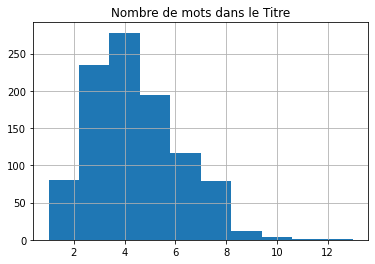

In [12]:
fig = plt.figure()
fig.patch.set_facecolor('w')
df_questions['qTitle'].hist(bins=10)
plt.title("Nombre de mots dans le Titre")

Text(0.5, 1.0, 'Nombre de mots dans les post')

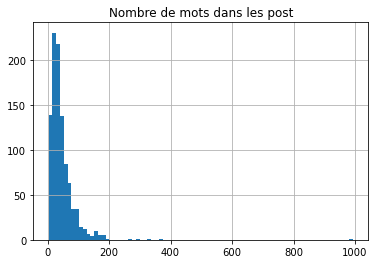

In [13]:
fig = plt.figure()
fig.patch.set_facecolor('w')
df_questions['qBody'].hist(bins=80)
plt.title("Nombre de mots dans les post")

## La plupart des titres ont environ 7 mots tandis que pour Body, il se situe autour de 35. Donc, pour obtenir les questions les plus similaires, nous allons utiliser le Title au lieu de Body.

## Word Cloud

In [14]:
def getWordCloud(df,col):
    comment_words = ''
    stopwords = set(STOPWORDS)
    stopwords.add('nan')
    stopwords.add('use')
    stopwords.add('way')
    stopwords.add('one')

    for val in tqdm(df[col]):

        val = str(val)
        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 800, height = 800,
                  background_color ='white',
                  stopwords = stopwords,
                  min_font_size = 10).generate(comment_words)


    plt.figure(figsize = (10, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)

    plt.show()

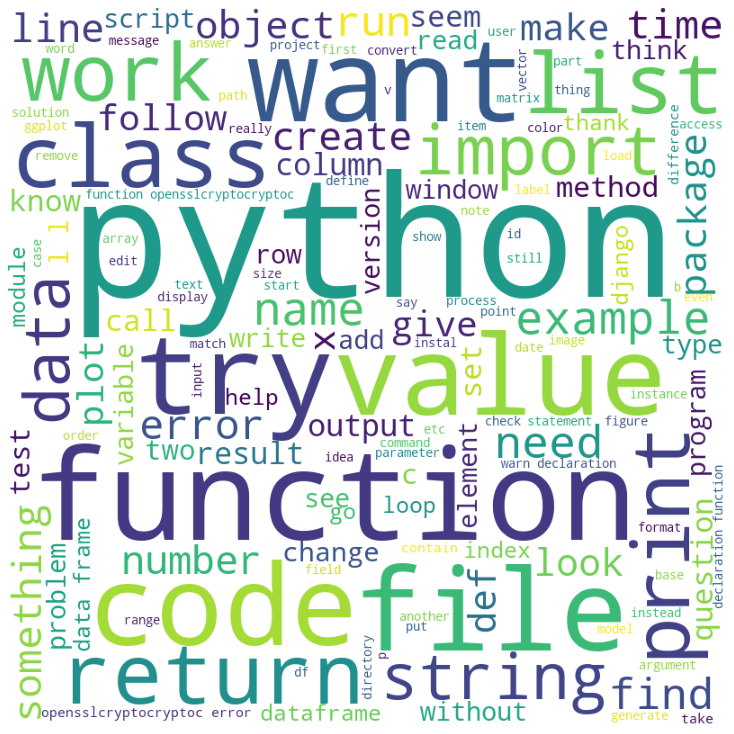

In [15]:
getWordCloud(df_questions,'Text')

## Prétraitement du titre - Suppression des mots vides, des caractères non alphanumériques et de tous les caractères en minuscules.

In [16]:
stop = stopwords.words('english')
def preprocess(df, col):
    df['preprocessed'+col] = df[col].apply(lambda x : " ".join([word for word in x.split(" ") if word not in stop]))
    df['preprocessed'+col] = df['preprocessed'+col].str.replace('[^a-zA-Z0-9 ]', '')
    df['preprocessed'+col] = df['preprocessed'+col].str.lower()
    return df

In [17]:
questions = preprocess(questions, 'Title')

NameError: name 'questions' is not defined

## Tags

In [18]:
tags = pd.read_csv("input/Tags.csv", encoding = "ISO-8859-1")
print(len(tags))
display(tags.head(5))

1885078


,Id,Tag
0,469,python
1,469,osx
2,469,fonts
3,469,photoshop
4,502,python


In [19]:
print("Nombre de tags uniques : ", tags['Tag'].nunique())
print("Nombre de tags uniques : ", df_tags_list['Tags'].nunique())

Nombre de tags uniques :  16895
Nombre de tags uniques :  3361


20 Tags les plus fréquents Sauf Python et r qui sont évidemment le plus fréquent.

<ipython-input-20-6be55a912b2f>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_tags_list[df_tags_list['Tags']!='python'][df_tags_list['Tags']!='r']['Tags'].value_counts().sort_values(ascending = False)[:20].plot(ax=ax, kind='bar')


<AxesSubplot:>

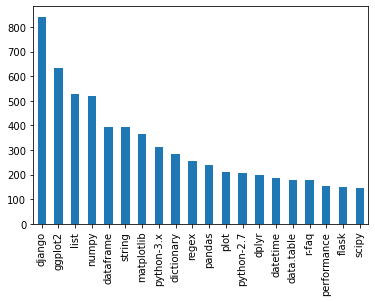

In [20]:
fig, ax = plt.subplots()

fig.patch.set_facecolor('w')
df_tags_list[df_tags_list['Tags']!='python'][df_tags_list['Tags']!='r']['Tags'].value_counts().sort_values(ascending = False)[:20].plot(ax=ax, kind='bar')

## Encoding the Processed Question Title and Embedding it using GPT2 Tokenizer. 

In [21]:
config_class, model_class, tokenizer_class = GPT2Config, GPT2LMHeadModel, GPT2Tokenizer
model = model_class.from_pretrained('gpt2')
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

In [22]:
preprocessedTitle = df_questions['Title'].values
QID = df_questions['Id'].values
print(len(preprocessedTitle), len(QID))

1000 1000


Utilisation de tokenizer.batch_encode_plus pour encoder tous les titres en une seule fois. Au lieu de tokenizer.batch_encode_plus, tokenizer.encode peut être utilisé pour encoder 1 instance à la fois

In [23]:
encodedpreprocessedTitle = tokenizer.batch_encode_plus(preprocessedTitle)['input_ids']
print(len(encodedpreprocessedTitle))

ValueError: Input is not valid. Should be a string, a list/tuple of strings or a list/tuple of integers.

Chargement de l’embedding à partir du modèle GPT2. Chaque token dans la "embedding matrix”  est un vecteur de longueur 768 et l’embedding a 50257 uniques tokens.

In [24]:
embeddigs = model.transformer.wte
print("Shape de l' embedding matrix : ",embeddigs.weight.shape)
print("Type de l' embedding matrix : ", type(embeddigs))

Shape de l' embedding matrix :  torch.Size([50257, 768])
Type de l' embedding matrix :  <class 'torch.nn.modules.sparse.Embedding'>


## Dans le code ci-dessous, Nous avons pris la moyenne à travers des embeddings de tous les tokens dans un titre particulier. Ainsi, après avoir pris la moyenne, chaque titre serait représenté par un vecteur de longueur 768. Et la même chose a été faite pour tous les 607282 titres dans une boucle for.
## Remarque - Il peut y avoir des cas où le nombre de jetons dans le titre traité peut être égal à 0, d'où la condition de len (encodedTitle)> 0 a été appliquée.

In [25]:
TitleEmbeddingList = []
QIDList = []
for idx, (qid, encodedTitle) in tqdm(enumerate(zip(QID, encodedpreprocessedTitle))):
    if len(encodedTitle) > 0 :
        embeddedTitle = embeddigs(torch.tensor(encodedTitle).to(torch.int64)).mean(axis=0)
        TitleEmbeddingList.append(embeddedTitle)
        QIDList.append(qid)

NameError: name 'encodedpreprocessedTitle' is not defined

In [26]:
numQ = len(TitleEmbeddingList)
embedDim = len(TitleEmbeddingList[0])
print("Nombre de Titres : ",numQ," et longueur du vecteur de chaque titre : ",embedDim)

IndexError: list index out of range

In [27]:
print("Type de TitleEmbeddingList : ",type(TitleEmbeddingList))

Type de TitleEmbeddingList :  <class 'list'>


## Conversion de TitleEmbeddingList de "liste de tenseurs" en tenseur.

In [28]:
TitleEmbeddingTensor = torch.cat(TitleEmbeddingList, dim=0)
TitleEmbeddingTensor = torch.reshape(TitleEmbeddingTensor, (numQ, embedDim))
print("Shape de TitleEmbeddingTensor : ",TitleEmbeddingTensor.shape)
print("Type de TitleEmbeddingTensor : ", type(TitleEmbeddingTensor))

RuntimeError: There were no tensor arguments to this function (e.g., you passed an empty list of Tensors), but no fallback function is registered for schema aten::_cat.  This usually means that this function requires a non-empty list of Tensors.  Available functions are [CPU, CUDA, QuantizedCPU, BackendSelect, Named, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradNestedTensor, UNKNOWN_TENSOR_TYPE_ID, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, Tracer, Autocast, Batched, VmapMode].

CPU: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/build/aten/src/ATen/RegisterCPU.cpp:5925 [kernel]
CUDA: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/build/aten/src/ATen/RegisterCUDA.cpp:7100 [kernel]
QuantizedCPU: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/build/aten/src/ATen/RegisterQuantizedCPU.cpp:641 [kernel]
BackendSelect: fallthrough registered at /opt/conda/conda-bld/pytorch_1616554788289/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Named: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
AutogradOther: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradCPU: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradCUDA: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradXLA: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradNestedTensor: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
UNKNOWN_TENSOR_TYPE_ID: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse1: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse2: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
AutogradPrivateUse3: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/autograd/generated/VariableType_2.cpp:9122 [autograd kernel]
Tracer: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/autograd/generated/TraceType_2.cpp:10525 [kernel]
Autocast: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/aten/src/ATen/autocast_mode.cpp:254 [kernel]
Batched: registered at /opt/conda/conda-bld/pytorch_1616554788289/work/aten/src/ATen/BatchingRegistrations.cpp:1016 [backend fallback]
VmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1616554788289/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]


# Une fois que nous avons créé la représentation avec l’embedding pour chaque titre. Nous allons maintenant entrer une question et rechercher parmi les titres de question StackOverflow lesquels sont les plus similaires à l'entrée en utilisant la similitude cosinus entre l’embedding de la question d'entrée et les titres.

## PreProcess du texte des titres

In [29]:
def preprocesstext(text):
    text =  " ".join([word for word in text.split(" ") if word not in stop])
    text = re.sub(r'[^a-zA-Z0-9 ]','',text)
    text = text.lower()
    return text

## Effectuer une similarité cosinus entre la question entrée et tous les titres StackOverFlow et obtenir l'index des titres K les plus similaires

In [30]:
def getMostSimilarQuestionsIdx(K, a, b):
    a_norm = a / a.norm(dim=1)[:, None]
    b_norm = b / b.norm(dim=1)[:, None]
    res = torch.mm(a_norm, b_norm.transpose(0,1)).squeeze(0)
    res = res.tolist()
    mostSimIdx = sorted(range(len(res)), key=lambda x: res[x])[-K:]
    return mostSimIdx

## Afficher les titres de questions les plus similaires avec l'ID de question et les tags associés

In [31]:
def getMostSimilarQuestions(K, input, QuestionDF, QIDList, Tags):
    input = input
    preprocessedinput = preprocesstext(input)
    inputEncoded = tokenizer.batch_encode_plus([preprocessedinput])['input_ids']
    inputEmbedded = embeddigs(torch.tensor(inputEncoded).to(torch.int64)).squeeze(0).mean(axis=0).unsqueeze(0)
    mostSimilarIdx = getMostSimilarQuestionsIdx(K, inputEmbedded, TitleEmbeddingTensor)
    mostSimilarIdx.reverse()
    print("Most similar ",K, " questions of : ",input,'\n')
    for idx, simidx in enumerate(mostSimilarIdx):
        IDQ = QuestionDF[QuestionDF['Id']==QIDList[simidx]][['Id','Title_raw']].values
        parentId = IDQ[0][0]
        simQuestion = IDQ[0][1]
        print((idx+1), "Question Id : ", parentId, "\n", "Question : ",simQuestion)
        similar_tags = Tags[Tags['Id']==QIDList[simidx]][['Tags']].values
        tags_list =  " , ".join([word for word in similar_tags[:,0]])
        print("Tags suggérés : ", tags_list, "\n")

## Test

In [32]:
tag_list=getMostSimilarQuestions(5, "How to MUltiply 2 columns pandas ?", df_questions ,QIDList, df_tags_list)

NameError: name 'TitleEmbeddingTensor' is not defined

In [33]:
getMostSimilarQuestions(5, "regex pandas", df_questions ,QIDList, df_tags_list)

NameError: name 'TitleEmbeddingTensor' is not defined

In [34]:
getMostSimilarQuestions(5, "logistic regression sklearn", df_questions ,QIDList, df_tags_list)

NameError: name 'TitleEmbeddingTensor' is not defined

In [35]:
getMostSimilarQuestions(5, "covert csv to json file pandas", df_questions ,QIDList, df_tags_list)

NameError: name 'TitleEmbeddingTensor' is not defined

In [36]:
getMostSimilarQuestions(5, "Build website using python", df_questions ,QIDList, df_tags_list)

NameError: name 'TitleEmbeddingTensor' is not defined

In [37]:
getMostSimilarQuestions(5, "How to install Pandas", df_questions ,QIDList, df_tags_list)

NameError: name 'TitleEmbeddingTensor' is not defined